 # 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。

keras/lstm_seq2seq.py at master · keras-team/keras

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2020-01-21 10:23:47--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3033::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5939832 (5.7M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   5.66M  7.22MB/s    in 0.8s    

2020-01-21 10:23:49 (7.22 MB/s) - ‘fra-eng.zip’ saved [5939832/5939832]



In [0]:
#zipファイルを解凍
!unzip fra-eng.zip


Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [0]:
import tensorflow as tf 
sess = tf.Session() 
sess.run(decoder_outputs) 

NameError: ignored

In [0]:
pwd

'/content'

In [0]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 2000 samples
Epoch 1/100





8000/8000 [==============================] - 21s 3ms/step - loss: 1.2062 - acc: 0.7228 - val_loss: 1.0839 - val_acc: 0.6981
Epoch 2/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.8730 - acc: 0.7627 - val_loss: 0.9076 - val_acc: 0.7464
Epoch 3/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.6983 - acc: 0.8054 - val_loss: 0.7328 - val_acc: 0.7876
Epoch 4/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.5978 - acc: 0.8264 - val_loss: 0.6600 - val_acc: 0.8057
Epoch 5/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.5477 - acc: 0.8392 - val_loss: 0.6196 - val_acc: 0.8161
E

 # 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。

データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。

注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!git clone https://github.com/pdollar/coco.git

Cloning into 'coco'...
remote: Enumerating objects: 965, done.
remote: Total 965 (delta 0), reused 0 (delta 0), pack-reused 965
Receiving objects: 100% (965/965), 11.69 MiB | 4.83 MiB/s, done.
Resolving deltas: 100% (574/574), done.


In [0]:
cd coco/PythonAPI/

/content/coco/PythonAPI


In [0]:
!make

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:

In [0]:
!python setup.py build

running build
running build_py
creating build
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.6/pycocotools
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-func

In [0]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating pycocotools.egg-info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/mask.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/_mask.cpython-36m-x86_64-linux-gnu.so -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__

In [0]:
!cd ../../

In [0]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 816, done.
remote: Total 816 (delta 0), reused 0 (delta 0), pack-reused 816
Receiving objects: 100% (816/816), 12.78 MiB | 3.77 MiB/s, done.
Resolving deltas: 100% (432/432), done.


In [0]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [0]:
# !pip install -r requirements.txt

In [0]:
pwd

'/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [0]:
!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip

--2020-01-08 10:36:44--  https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/26adb7y9m98uisa/vocap.zip [following]
--2020-01-08 10:36:45--  https://www.dropbox.com/s/raw/26adb7y9m98uisa/vocap.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8d228f048850f4b88f931427fd.dl.dropboxusercontent.com/cd/0/inline/Avx2A6g_HNHF8r0HLLYlcqAMrfdJzTHO3YQgESlSCu7g967gtkLknPlzbZ6cTvFb42tNmHVKprAbd5LL4cnvPJdO_bs7vUvNZs3kQbjY4TrSU3hVSWXv_0kC5f2sMujIxzA/file# [following]
--2020-01-08 10:36:45--  https://uc8d228f048850f4b88f931427fd.dl.dropboxusercontent.com/cd/0/inline/Avx2A6g_HNHF8r0HLLYlcqAMrfdJzTHO3YQgESlSCu7g967gtkLknPlzbZ6cTvFb42tNmHVKprAbd5LL4cnvPJdO_bs7vUvNZs3kQbjY4TrSU3hVSWXv_0kC5f

In [0]:
!mkdir models

In [0]:
pwd

'/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [0]:
!unzip vocap.zip -d data

Archive:  vocap.zip
  inflating: data/vocab.pkl          


In [0]:
pwd

'/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [0]:
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0

--2020-01-08 10:37:08--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2020-01-08 10:37:09--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf6da3d8dc2c293579e2d4cda72.dl.dropboxusercontent.com/cd/0/inline/AvzOxPOMcakFqXnGF2Nkln_Wu7xcHbrssstbHHChUT9hY7WljBJwrMVfzxxzeIw0TOC0HdiIpJn1ki0Ti4dqAx8PW8ZejhTbLbyxteiFT_Taj69jilVhUhpzI9BL2cJ85_M/file# [following]
--2020-01-08 10:37:10--  https://ucf6da3d8dc2c293579e2d4cda72.dl.dropboxusercontent.com/cd/0/inline/AvzOxPOMcakFqXnGF2Nkln_Wu7xcHbrssstbHHChUT9hY7WljBJwrMVfzxxzeIw0TOC0HdiIpJn1ki0Ti4dq

In [0]:
pwd

'/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [0]:
# !mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
ls

 build_vocab.py   index.html  'pretrained_model.zip?dl=0'   sample.py
 data/            model.py     README.md                    train.py
 data_loader.py   models/      requirements.txt             vocap.zip
 download.sh*     png/         resize.py


In [0]:
# cd /content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [0]:
!unzip pretrained_model.zip?dl=0 -d models

Archive:  pretrained_model.zip?dl=0
  inflating: models/encoder-5-3000.pkl  
  inflating: models/decoder-5-3000.pkl  


In [0]:
# !mv data/decoder-5-3000.pkl models/

In [0]:
# !mv data/encoder-5-3000.pkl models/

In [0]:
# !mv models/vocab.pkl data/

In [0]:
pwd

'/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [0]:
!grep -l 'encoder-2-1000.ckpt' ./* | xargs sed -i.bak -e 's/encoder-2-1000.ckpt/encoder-5-3000.pkl/g'

grep: ./data: Is a directory
grep: ./models: Is a directory
grep: ./png: Is a directory


In [0]:
!grep -l 'decoder-2-1000.ckpt' ./* | xargs sed -i.bak -e 's/decoder-2-1000.ckpt/decoder-5-3000.pkl/g'

grep: ./data: Is a directory
grep: ./models: Is a directory
grep: ./png: Is a directory


In [0]:
!python sample.py --image='png/example.png'

<start> a group of giraffes standing next to each other . <end>


In [0]:
!mkdir img

mkdir: cannot create directory ‘img’: File exists


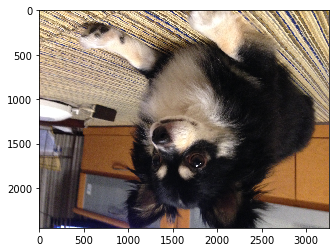

<start> a cat is sitting on a couch with a cat . <end>


In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image
 
 
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image
 
def main():
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
 
    # Build models
    encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)
 
    # Load the trained model parameters
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))
 
    # Prepare an image
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    image = Image.open(image_path)
    plt.imshow(np.asarray(image))
    plt.show()
    print (sentence)
    
if __name__ == '__main__':
    encoder_path ='models/encoder-5-3000.pkl'
    decoder_path ='models/decoder-5-3000.pkl'
    vocab_path ='data/vocab.pkl'
    
    # Model parameters (should be same as paramters in train.py)
    embed_size=256
    hidden_size=512
    num_layers=1
    
    import glob
    files = sorted(glob.glob('img/*.jpg'))
    for i, image_path in enumerate (files):   
        main()

In [0]:
!mv /content/surfin.jpeg /content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/img

In [0]:
main

<function __main__.main>

In [0]:
ls

 build_vocab.py   index.html                   __pycache__/       train.py
 data/            model.py                     README.md          vocap.zip
 data_loader.py   models/                      requirements.txt
 download.sh*     png/                         resize.py
 img/            'pretrained_model.zip?dl=0'   sample.py


 # 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。

特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

 ## MMdnnを利用する
MMdnnとは，Microsoft Researchにより開発が進められているオープンソースの深層学習モデルの変換と可視化を行うツール．Caffe、Keras、Tensorflow、CNTK、MXNet、PyTorch、CoreMLなどのフレームワークが相互運用可能になる．

 ## 使い方（簡単に）
 - pip install mmdnnでインストールできる
 - mmdownload -f keras -n inception_v3 -o ./で学習済みの重みもダウンロードできる
 - mmconvert -sf keras -iw imagenet_inception_v3.h5 -df onnx -om imagenet_inception_v3.onnxで、「imagenet_inception_v3.h5」というkerasモデルファイルに対して、「imagenet_inception_v3.onnx」というファイルが生成される。それにより、モデルをONNXモデルに変換できる。
 <br>
参考記事 : https://qiita.com/koppe/items/7f85f5411539390c4499